In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'chromatic_aberration', 'low_resolution', 'blur', 'lens_flare', 'motion_blur', 'gaussian_noise', 'dirty_lens'}
Validation folders considered: {'original', 'chromatic_aberration', 'low_resolution', 'blur', 'lens_flare', 'motion_blur', 'gaussian_noise', 'dirty_lens'}
Test folders considered: {'original', 'chromatic_aberration', 'low_resolution', 'blur', 'lens_flare', 'motion_blur', 'gaussian_noise', 'dirty_lens'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'chromatic_aberration', 'low_resolution', 'blur', 'lens_flare', 'motion_blur', 'gaussian_noise', 'dirty_lens'}
Validation folders considered: {'original', 'chromatic_aberration', 'low_resolution', 'blur', 'lens_flare', 'motion_blur', 'gaussian_noise', 'dirty_lens'}
Test folders considered: {'original', 'chromatic_aberration', 'low_resolution', 'blur', 'lens_flare', 'motion_blur', 'gaussian_noise', 'dirty_lens'}


In [7]:
# -----------------------------
# 2. Define Vision Transformer (ViT) Model from Scratch
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
import math

class PatchEmbedding(nn.Module):
    """Patch Embedding Layer - Convert image to patches and embed them"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Use Conv2d to create patch embeddings
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H', W') where H' = H/patch_size, W' = W/patch_size
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""
    def __init__(self, embed_dim=768, n_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        assert self.head_dim * n_heads == embed_dim, "embed_dim must be divisible by n_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_heads, N, head_dim)
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

class MLP(nn.Module):
    """Multi-Layer Perceptron (Feed-Forward Network)"""
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.1):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer Encoder Block"""
    def __init__(self, embed_dim=768, n_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, mlp_hidden_dim, dropout=dropout)
        
    def forward(self, x):
        # Pre-norm architecture (Layer Norm before attention and MLP)
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class MyVisionTransformer(nn.Module):
    """Vision Transformer (ViT) Implementation from Scratch"""
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=4, 
                 embed_dim=768, depth=12, n_heads=12, mlp_ratio=4.0, dropout=0.1, 
                 emb_dropout=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.num_tokens = 1  # CLS token
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches
        
        # CLS token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(emb_dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights"""
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize other weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
            elif isinstance(m, nn.Conv2d):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        B = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, n_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final layer norm and classification
        x = self.norm(x)
        
        # Use CLS token for classification
        cls_token_final = x[:, 0]  # (B, embed_dim)
        x = self.head(cls_token_final)  # (B, num_classes)
        
        return x

In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ViT-Base configuration
model = MyVisionTransformer(
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=len(classes),
    embed_dim=768,
    depth=12,
    n_heads=12,
    mlp_ratio=4.0,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)  # Lower LR for ViT

print("Vision Transformer (ViT) Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

Vision Transformer (ViT) Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
    PatchEmbedding-2             [-1, 196, 768]               0
           Dropout-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6         [-1, 12, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8             [-1, 197, 768]               0
MultiHeadAttention-9             [-1, 197, 768]               0
        LayerNorm-10             [-1, 197, 768]           1,536
           Linear-11            [-1, 197, 3072]       2,362,368
             GELU-12            [-1, 197, 3072]               0
          Dropout-13            [-1, 197, 3072]               0


🚀 Starting Vision Transformer Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:23<00:00,  1.55s/it, Loss=1.5647, Acc=0.3415]


✅ Training completed in 83.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, Loss=1.8174, Acc=0.2902]


✅ Validation completed in 10.75s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.2902

📊 Epoch 1 Summary:
│ Train Loss: 1.5647 | Train Acc: 0.3415
│ Val Loss:   1.8174 | Val Acc:   0.2902
│ Train Time: 83.55s | Val Time: 10.75s
│ Total Epoch Time: 94.30s
│ Best Val Acc: 0.2902 (Epoch 1)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.5332, Acc=0.3691]


✅ Training completed in 78.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.7136, Acc=0.3929]


✅ Validation completed in 8.45s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.3929

📊 Epoch 2 Summary:
│ Train Loss: 1.5332 | Train Acc: 0.3691
│ Val Loss:   1.7136 | Val Acc:   0.3929
│ Train Time: 78.18s | Val Time: 8.45s
│ Total Epoch Time: 86.64s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.5081, Acc=0.3908]


✅ Training completed in 78.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.9126, Acc=0.2165]


✅ Validation completed in 8.53s

📊 Epoch 3 Summary:
│ Train Loss: 1.5081 | Train Acc: 0.3908
│ Val Loss:   1.9126 | Val Acc:   0.2165
│ Train Time: 78.17s | Val Time: 8.53s
│ Total Epoch Time: 86.70s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4695, Acc=0.3820]


✅ Training completed in 77.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.6436, Acc=0.3348]


✅ Validation completed in 8.46s

📊 Epoch 4 Summary:
│ Train Loss: 1.4695 | Train Acc: 0.3820
│ Val Loss:   1.6436 | Val Acc:   0.3348
│ Train Time: 77.99s | Val Time: 8.46s
│ Total Epoch Time: 86.45s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.4754, Acc=0.3867]


✅ Training completed in 78.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, Loss=1.6317, Acc=0.3482]


✅ Validation completed in 8.59s

📊 Epoch 5 Summary:
│ Train Loss: 1.4754 | Train Acc: 0.3867
│ Val Loss:   1.6317 | Val Acc:   0.3482
│ Train Time: 78.19s | Val Time: 8.59s
│ Total Epoch Time: 86.78s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.4463, Acc=0.3791]


✅ Training completed in 78.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.8175, Acc=0.3616]


✅ Validation completed in 8.46s

📊 Epoch 6 Summary:
│ Train Loss: 1.4463 | Train Acc: 0.3791
│ Val Loss:   1.8175 | Val Acc:   0.3616
│ Train Time: 78.19s | Val Time: 8.46s
│ Total Epoch Time: 86.65s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4672, Acc=0.3844]


✅ Training completed in 77.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.6947, Acc=0.2321]


✅ Validation completed in 8.53s

📊 Epoch 7 Summary:
│ Train Loss: 1.4672 | Train Acc: 0.3844
│ Val Loss:   1.6947 | Val Acc:   0.2321
│ Train Time: 77.95s | Val Time: 8.53s
│ Total Epoch Time: 86.49s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4604, Acc=0.3685]


✅ Training completed in 77.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, Loss=1.5870, Acc=0.3192]


✅ Validation completed in 8.63s

📊 Epoch 8 Summary:
│ Train Loss: 1.4604 | Train Acc: 0.3685
│ Val Loss:   1.5870 | Val Acc:   0.3192
│ Train Time: 77.82s | Val Time: 8.63s
│ Total Epoch Time: 86.45s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4770, Acc=0.3691]


✅ Training completed in 77.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, Loss=1.5302, Acc=0.3638]


✅ Validation completed in 8.58s

📊 Epoch 9 Summary:
│ Train Loss: 1.4770 | Train Acc: 0.3691
│ Val Loss:   1.5302 | Val Acc:   0.3638
│ Train Time: 77.98s | Val Time: 8.58s
│ Total Epoch Time: 86.57s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4445, Acc=0.3867]


✅ Training completed in 77.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.5058, Acc=0.3549]


✅ Validation completed in 8.43s

📊 Epoch 10 Summary:
│ Train Loss: 1.4445 | Train Acc: 0.3867
│ Val Loss:   1.5058 | Val Acc:   0.3549
│ Train Time: 77.81s | Val Time: 8.43s
│ Total Epoch Time: 86.25s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4602, Acc=0.3744]


✅ Training completed in 77.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.5499, Acc=0.2812]


✅ Validation completed in 8.52s

📊 Epoch 11 Summary:
│ Train Loss: 1.4602 | Train Acc: 0.3744
│ Val Loss:   1.5499 | Val Acc:   0.2812
│ Train Time: 77.79s | Val Time: 8.52s
│ Total Epoch Time: 86.32s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4801, Acc=0.3768]


✅ Training completed in 77.70s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.5601, Acc=0.3438]


✅ Validation completed in 8.44s

📊 Epoch 12 Summary:
│ Train Loss: 1.4801 | Train Acc: 0.3768
│ Val Loss:   1.5601 | Val Acc:   0.3438
│ Train Time: 77.70s | Val Time: 8.44s
│ Total Epoch Time: 86.15s
│ Best Val Acc: 0.3929 (Epoch 2)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.4202, Acc=0.3938]


✅ Training completed in 77.79s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.5587, Acc=0.4040]


✅ Validation completed in 8.47s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.4040

📊 Epoch 13 Summary:
│ Train Loss: 1.4202 | Train Acc: 0.3938
│ Val Loss:   1.5587 | Val Acc:   0.4040
│ Train Time: 77.79s | Val Time: 8.47s
│ Total Epoch Time: 86.27s
│ Best Val Acc: 0.4040 (Epoch 13)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.4059, Acc=0.4184]


✅ Training completed in 78.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.4723, Acc=0.3795]


✅ Validation completed in 8.55s

📊 Epoch 14 Summary:
│ Train Loss: 1.4059 | Train Acc: 0.4184
│ Val Loss:   1.4723 | Val Acc:   0.3795
│ Train Time: 78.06s | Val Time: 8.55s
│ Total Epoch Time: 86.61s
│ Best Val Acc: 0.4040 (Epoch 13)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.4136, Acc=0.3955]


✅ Training completed in 78.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.5087, Acc=0.3728]


✅ Validation completed in 8.53s

📊 Epoch 15 Summary:
│ Train Loss: 1.4136 | Train Acc: 0.3955
│ Val Loss:   1.5087 | Val Acc:   0.3728
│ Train Time: 78.20s | Val Time: 8.53s
│ Total Epoch Time: 86.73s
│ Best Val Acc: 0.4040 (Epoch 13)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.3895, Acc=0.4237]


✅ Training completed in 78.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, Loss=1.5104, Acc=0.3906]


✅ Validation completed in 8.63s

📊 Epoch 16 Summary:
│ Train Loss: 1.3895 | Train Acc: 0.4237
│ Val Loss:   1.5104 | Val Acc:   0.3906
│ Train Time: 78.05s | Val Time: 8.63s
│ Total Epoch Time: 86.68s
│ Best Val Acc: 0.4040 (Epoch 13)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.3741, Acc=0.4290]


✅ Training completed in 77.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.5460, Acc=0.4174]


✅ Validation completed in 8.53s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.4174

📊 Epoch 17 Summary:
│ Train Loss: 1.3741 | Train Acc: 0.4290
│ Val Loss:   1.5460 | Val Acc:   0.4174
│ Train Time: 77.98s | Val Time: 8.53s
│ Total Epoch Time: 86.52s
│ Best Val Acc: 0.4174 (Epoch 17)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.3716, Acc=0.4249]


✅ Training completed in 77.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4719, Acc=0.3795]


✅ Validation completed in 8.47s

📊 Epoch 18 Summary:
│ Train Loss: 1.3716 | Train Acc: 0.4249
│ Val Loss:   1.4719 | Val Acc:   0.3795
│ Train Time: 77.92s | Val Time: 8.47s
│ Total Epoch Time: 86.40s
│ Best Val Acc: 0.4174 (Epoch 17)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.3452, Acc=0.4454]


✅ Training completed in 78.16s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4653, Acc=0.3728]


✅ Validation completed in 8.48s

📊 Epoch 19 Summary:
│ Train Loss: 1.3452 | Train Acc: 0.4454
│ Val Loss:   1.4653 | Val Acc:   0.3728
│ Train Time: 78.16s | Val Time: 8.48s
│ Total Epoch Time: 86.64s
│ Best Val Acc: 0.4174 (Epoch 17)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.3396, Acc=0.4536]


✅ Training completed in 78.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4419, Acc=0.3884]


✅ Validation completed in 8.49s

📊 Epoch 20 Summary:
│ Train Loss: 1.3396 | Train Acc: 0.4536
│ Val Loss:   1.4419 | Val Acc:   0.3884
│ Train Time: 78.18s | Val Time: 8.49s
│ Total Epoch Time: 86.68s
│ Best Val Acc: 0.4174 (Epoch 17)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.3224, Acc=0.4431]


✅ Training completed in 78.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.5228, Acc=0.3862]


✅ Validation completed in 8.52s

📊 Epoch 21 Summary:
│ Train Loss: 1.3224 | Train Acc: 0.4431
│ Val Loss:   1.5228 | Val Acc:   0.3862
│ Train Time: 78.15s | Val Time: 8.52s
│ Total Epoch Time: 86.67s
│ Best Val Acc: 0.4174 (Epoch 17)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.3063, Acc=0.4442]


✅ Training completed in 78.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, Loss=1.4558, Acc=0.4353]


✅ Validation completed in 8.63s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.4353

📊 Epoch 22 Summary:
│ Train Loss: 1.3063 | Train Acc: 0.4442
│ Val Loss:   1.4558 | Val Acc:   0.4353
│ Train Time: 78.10s | Val Time: 8.63s
│ Total Epoch Time: 86.73s
│ Best Val Acc: 0.4353 (Epoch 22)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.3051, Acc=0.4589]


✅ Training completed in 77.94s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.4754, Acc=0.3973]


✅ Validation completed in 8.56s

📊 Epoch 23 Summary:
│ Train Loss: 1.3051 | Train Acc: 0.4589
│ Val Loss:   1.4754 | Val Acc:   0.3973
│ Train Time: 77.94s | Val Time: 8.56s
│ Total Epoch Time: 86.50s
│ Best Val Acc: 0.4353 (Epoch 22)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2926, Acc=0.4519]


✅ Training completed in 77.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4567, Acc=0.4464]


✅ Validation completed in 8.50s
🌟 New best Vision Transformer model found! Validation Accuracy: 0.4464

📊 Epoch 24 Summary:
│ Train Loss: 1.2926 | Train Acc: 0.4519
│ Val Loss:   1.4567 | Val Acc:   0.4464
│ Train Time: 77.71s | Val Time: 8.50s
│ Total Epoch Time: 86.21s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2979, Acc=0.4601]


✅ Training completed in 77.82s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.4601, Acc=0.3862]


✅ Validation completed in 8.55s

📊 Epoch 25 Summary:
│ Train Loss: 1.2979 | Train Acc: 0.4601
│ Val Loss:   1.4601 | Val Acc:   0.3862
│ Train Time: 77.82s | Val Time: 8.55s
│ Total Epoch Time: 86.37s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2991, Acc=0.4560]


✅ Training completed in 77.81s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4287, Acc=0.3638]


✅ Validation completed in 8.47s

📊 Epoch 26 Summary:
│ Train Loss: 1.2991 | Train Acc: 0.4560
│ Val Loss:   1.4287 | Val Acc:   0.3638
│ Train Time: 77.81s | Val Time: 8.47s
│ Total Epoch Time: 86.29s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2978, Acc=0.4478]


✅ Training completed in 77.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4581, Acc=0.4375]


✅ Validation completed in 8.48s

📊 Epoch 27 Summary:
│ Train Loss: 1.2978 | Train Acc: 0.4478
│ Val Loss:   1.4581 | Val Acc:   0.4375
│ Train Time: 77.84s | Val Time: 8.48s
│ Total Epoch Time: 86.32s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.2751, Acc=0.4683]


✅ Training completed in 78.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4691, Acc=0.3482]


✅ Validation completed in 8.48s

📊 Epoch 28 Summary:
│ Train Loss: 1.2751 | Train Acc: 0.4683
│ Val Loss:   1.4691 | Val Acc:   0.3482
│ Train Time: 78.13s | Val Time: 8.48s
│ Total Epoch Time: 86.61s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.44s/it, Loss=1.2991, Acc=0.4525]


✅ Training completed in 78.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.4708, Acc=0.3393]


✅ Validation completed in 8.42s

📊 Epoch 29 Summary:
│ Train Loss: 1.2991 | Train Acc: 0.4525
│ Val Loss:   1.4708 | Val Acc:   0.3393
│ Train Time: 78.02s | Val Time: 8.42s
│ Total Epoch Time: 86.44s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.44s/it, Loss=1.2655, Acc=0.4648]


✅ Training completed in 78.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.5678, Acc=0.3393]


✅ Validation completed in 8.53s

📊 Epoch 30 Summary:
│ Train Loss: 1.2655 | Train Acc: 0.4648
│ Val Loss:   1.5678 | Val Acc:   0.3393
│ Train Time: 78.01s | Val Time: 8.53s
│ Total Epoch Time: 86.54s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.44s/it, Loss=1.2804, Acc=0.4712]


✅ Training completed in 78.02s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.5022, Acc=0.4040]


✅ Validation completed in 8.53s

📊 Epoch 31 Summary:
│ Train Loss: 1.2804 | Train Acc: 0.4712
│ Val Loss:   1.5022 | Val Acc:   0.4040
│ Train Time: 78.02s | Val Time: 8.53s
│ Total Epoch Time: 86.55s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2732, Acc=0.4883]


✅ Training completed in 77.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, Loss=1.4101, Acc=0.4062]


✅ Validation completed in 8.63s

📊 Epoch 32 Summary:
│ Train Loss: 1.2732 | Train Acc: 0.4883
│ Val Loss:   1.4101 | Val Acc:   0.4062
│ Train Time: 77.77s | Val Time: 8.63s
│ Total Epoch Time: 86.40s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2617, Acc=0.4707]


✅ Training completed in 77.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4722, Acc=0.3973]


✅ Validation completed in 8.49s

📊 Epoch 33 Summary:
│ Train Loss: 1.2617 | Train Acc: 0.4707
│ Val Loss:   1.4722 | Val Acc:   0.3973
│ Train Time: 77.84s | Val Time: 8.49s
│ Total Epoch Time: 86.33s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2915, Acc=0.4777]


✅ Training completed in 77.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4210, Acc=0.4062]


✅ Validation completed in 8.49s

📊 Epoch 34 Summary:
│ Train Loss: 1.2915 | Train Acc: 0.4777
│ Val Loss:   1.4210 | Val Acc:   0.4062
│ Train Time: 77.96s | Val Time: 8.49s
│ Total Epoch Time: 86.45s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2649, Acc=0.4847]


✅ Training completed in 77.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.4506, Acc=0.3750]


✅ Validation completed in 8.42s

📊 Epoch 35 Summary:
│ Train Loss: 1.2649 | Train Acc: 0.4847
│ Val Loss:   1.4506 | Val Acc:   0.3750
│ Train Time: 77.93s | Val Time: 8.42s
│ Total Epoch Time: 86.35s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2870, Acc=0.4589]


✅ Training completed in 77.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.5091, Acc=0.3214]


✅ Validation completed in 8.43s

📊 Epoch 36 Summary:
│ Train Loss: 1.2870 | Train Acc: 0.4589
│ Val Loss:   1.5091 | Val Acc:   0.3214
│ Train Time: 77.93s | Val Time: 8.43s
│ Total Epoch Time: 86.36s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2652, Acc=0.4759]


✅ Training completed in 77.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.5752, Acc=0.3661]


✅ Validation completed in 8.45s

📊 Epoch 37 Summary:
│ Train Loss: 1.2652 | Train Acc: 0.4759
│ Val Loss:   1.5752 | Val Acc:   0.3661
│ Train Time: 77.98s | Val Time: 8.45s
│ Total Epoch Time: 86.43s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2731, Acc=0.4783]


✅ Training completed in 77.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4002, Acc=0.4040]


✅ Validation completed in 8.50s

📊 Epoch 38 Summary:
│ Train Loss: 1.2731 | Train Acc: 0.4783
│ Val Loss:   1.4002 | Val Acc:   0.4040
│ Train Time: 77.90s | Val Time: 8.50s
│ Total Epoch Time: 86.41s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.2365, Acc=0.5000]


✅ Training completed in 78.08s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.4741, Acc=0.3772]


✅ Validation completed in 8.56s

📊 Epoch 39 Summary:
│ Train Loss: 1.2365 | Train Acc: 0.5000
│ Val Loss:   1.4741 | Val Acc:   0.3772
│ Train Time: 78.08s | Val Time: 8.56s
│ Total Epoch Time: 86.65s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.3227, Acc=0.4536]


✅ Training completed in 77.76s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.5513, Acc=0.4018]


✅ Validation completed in 8.49s

📊 Epoch 40 Summary:
│ Train Loss: 1.3227 | Train Acc: 0.4536
│ Val Loss:   1.5513 | Val Acc:   0.4018
│ Train Time: 77.76s | Val Time: 8.49s
│ Total Epoch Time: 86.26s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.2867, Acc=0.4642]


✅ Training completed in 78.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.61it/s, Loss=1.4715, Acc=0.4018]


✅ Validation completed in 8.69s

📊 Epoch 41 Summary:
│ Train Loss: 1.2867 | Train Acc: 0.4642
│ Val Loss:   1.4715 | Val Acc:   0.4018
│ Train Time: 78.12s | Val Time: 8.69s
│ Total Epoch Time: 86.81s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2643, Acc=0.4888]


✅ Training completed in 77.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4194, Acc=0.4152]


✅ Validation completed in 8.49s

📊 Epoch 42 Summary:
│ Train Loss: 1.2643 | Train Acc: 0.4888
│ Val Loss:   1.4194 | Val Acc:   0.4152
│ Train Time: 77.93s | Val Time: 8.49s
│ Total Epoch Time: 86.42s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2622, Acc=0.4812]


✅ Training completed in 77.93s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, Loss=1.4974, Acc=0.3951]


✅ Validation completed in 8.60s

📊 Epoch 43 Summary:
│ Train Loss: 1.2622 | Train Acc: 0.4812
│ Val Loss:   1.4974 | Val Acc:   0.3951
│ Train Time: 77.93s | Val Time: 8.60s
│ Total Epoch Time: 86.53s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2622, Acc=0.4759]


✅ Training completed in 77.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.67it/s, Loss=1.5278, Acc=0.4286]


✅ Validation completed in 8.40s

📊 Epoch 44 Summary:
│ Train Loss: 1.2622 | Train Acc: 0.4759
│ Val Loss:   1.5278 | Val Acc:   0.4286
│ Train Time: 77.89s | Val Time: 8.40s
│ Total Epoch Time: 86.29s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2442, Acc=0.4877]


✅ Training completed in 77.65s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4478, Acc=0.3772]


✅ Validation completed in 8.49s

📊 Epoch 45 Summary:
│ Train Loss: 1.2442 | Train Acc: 0.4877
│ Val Loss:   1.4478 | Val Acc:   0.3772
│ Train Time: 77.65s | Val Time: 8.49s
│ Total Epoch Time: 86.15s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2313, Acc=0.4906]


✅ Training completed in 77.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.5260, Acc=0.3772]


✅ Validation completed in 8.50s

📊 Epoch 46 Summary:
│ Train Loss: 1.2313 | Train Acc: 0.4906
│ Val Loss:   1.5260 | Val Acc:   0.3772
│ Train Time: 77.98s | Val Time: 8.50s
│ Total Epoch Time: 86.48s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.45s/it, Loss=1.2252, Acc=0.4965]


✅ Training completed in 78.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, Loss=1.4535, Acc=0.3951]


✅ Validation completed in 8.47s

📊 Epoch 47 Summary:
│ Train Loss: 1.2252 | Train Acc: 0.4965
│ Val Loss:   1.4535 | Val Acc:   0.3951
│ Train Time: 78.06s | Val Time: 8.47s
│ Total Epoch Time: 86.53s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:18<00:00,  1.44s/it, Loss=1.2408, Acc=0.4988]


✅ Training completed in 78.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, Loss=1.5112, Acc=0.3929]


✅ Validation completed in 8.63s

📊 Epoch 48 Summary:
│ Train Loss: 1.2408 | Train Acc: 0.4988
│ Val Loss:   1.5112 | Val Acc:   0.3929
│ Train Time: 78.01s | Val Time: 8.63s
│ Total Epoch Time: 86.64s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2766, Acc=0.4736]


✅ Training completed in 77.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=1.4276, Acc=0.4219]


✅ Validation completed in 8.44s

📊 Epoch 49 Summary:
│ Train Loss: 1.2766 | Train Acc: 0.4736
│ Val Loss:   1.4276 | Val Acc:   0.4219
│ Train Time: 77.89s | Val Time: 8.44s
│ Total Epoch Time: 86.33s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [01:17<00:00,  1.44s/it, Loss=1.2543, Acc=0.4994]


✅ Training completed in 77.59s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=1.4121, Acc=0.4219]


✅ Validation completed in 8.56s

📊 Epoch 50 Summary:
│ Train Loss: 1.2543 | Train Acc: 0.4994
│ Val Loss:   1.4121 | Val Acc:   0.4219
│ Train Time: 77.59s | Val Time: 8.56s
│ Total Epoch Time: 86.15s
│ Best Val Acc: 0.4464 (Epoch 24)
│ GPU Memory: 1.3GB / 6.7GB

💾 Best Vision Transformer model saved as 'best_vit_model.pth'
📊 Best model stats:
│ Best Epoch: 24
│ Best Val Acc: 0.4464

💾 Vision Transformer training history saved to 'vit_training_history.csv'

🎉 Vision Transformer Training Complete!
Total Training Time: 4331.52s (72.2 minutes)
Average Epoch Time: 86.63s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 94.30s
│ Epoch 2: 86.64s
│ Epoch 3: 86.70s
│ Epoch 4: 86.45s
│ Epoch 5: 86.78s
│ Epoch 6: 86.65s
│ Epoch 7: 86.49s
│ Epoch 8: 86.45s
│ Epoch 9: 86.57s
│ Epoch 10: 86.25s
│ Epoch 11: 86.32s
│ Epoch 12: 86.15s
│ Epoch 13: 86.27s
│ Epoch 14: 86.61s
│ Epoch 15: 86.73s
│ Epoch 16: 86.68s
│ Epoch 17: 86.52s
│ Epoch 18: 86.40s
│ Epoch 19: 86.64s
│ Epoch 20: 86.68s
│ Epoch 21: 86.67s
│ Epoch

Testing Vision Transformer: 100%|██████████████████████████████| 18/18 [00:15<00:00,  1.18it/s]


✅ Vision Transformer Testing completed in 15.30s

📋 Vision Transformer Classification Report:
                 precision    recall  f1-score   support

  boundary_save       0.45      0.66      0.54       152
catching_a_ball       0.00      0.00      0.00       104
    diving_stop       0.00      0.00      0.00        56
        run_out       0.45      0.48      0.46       128
       stumping       0.25      0.35      0.29       120

       accuracy                           0.36       560
      macro avg       0.23      0.30      0.26       560
   weighted avg       0.28      0.36      0.31       560

🎯 Vision Transformer Test Accuracy: 0.3643

📊 Vision Transformer Model Performance Summary:
│ Best Validation Acc:  0.4464 (Epoch 24)
│ Final Test Accuracy:  0.3643
│ Val-Test Gap:         0.0821


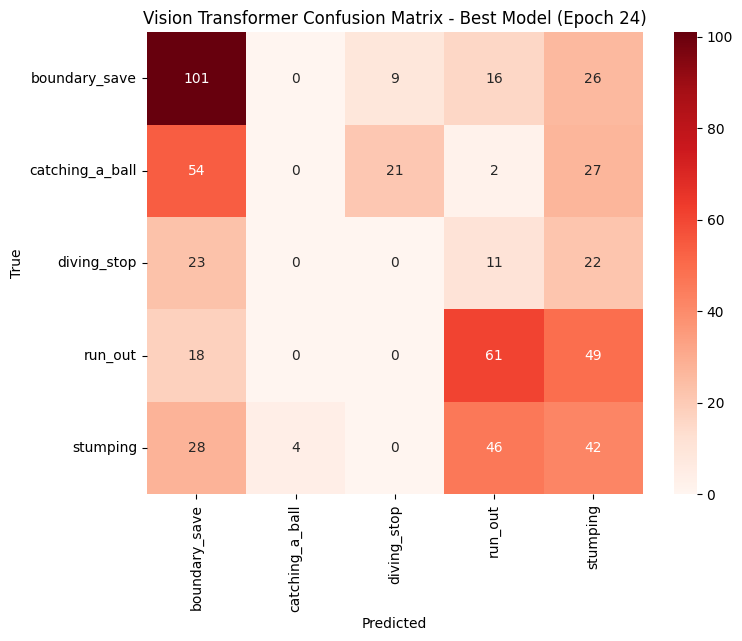

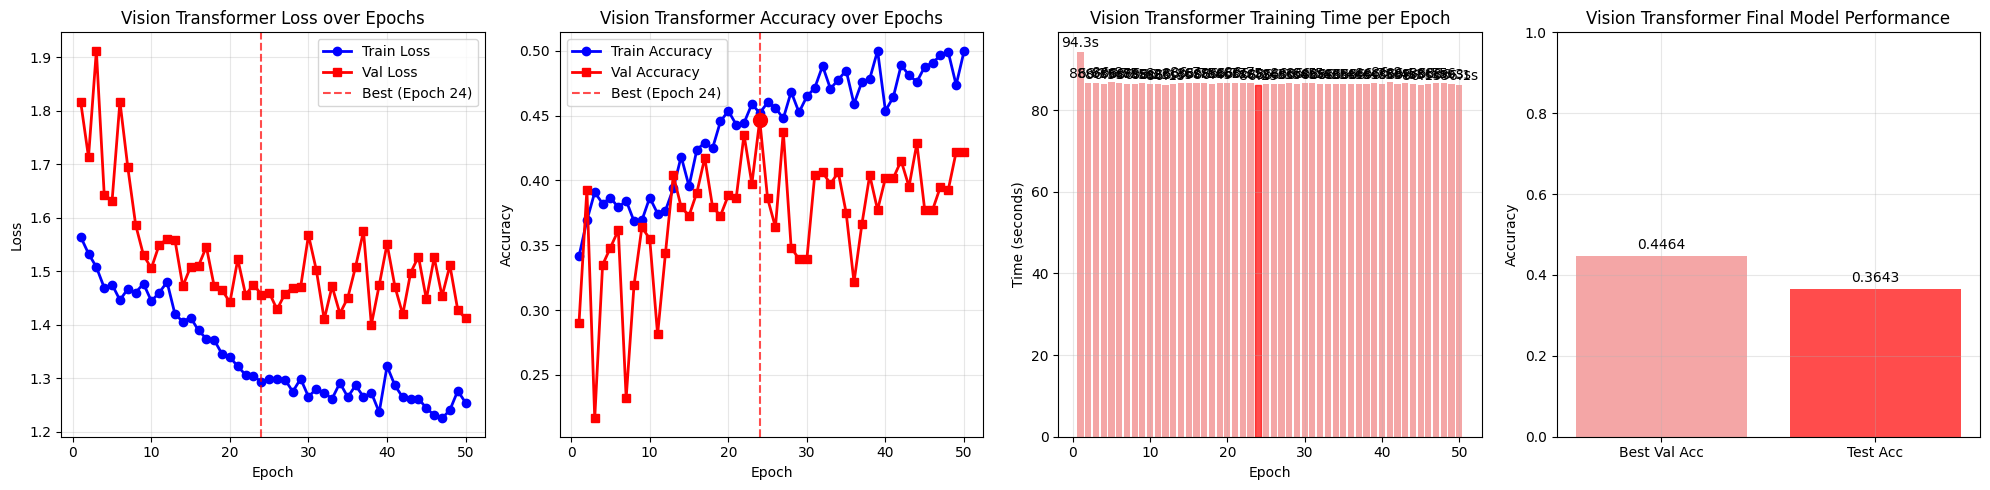


⏰ Vision Transformer Final Timing Summary:
│ Total Training: 4331.52s
│ Average per Epoch: 86.63s
│ Testing Time: 15.30s
│ Total Runtime: 4346.82s

💾 Vision Transformer Files saved:
│ best_vit_model.pth - Best validation accuracy model
│ vit_training_history.csv - Training metrics for later plotting

🏗️  Vision Transformer Architecture Summary:
│ Total Parameters: 85,802,501
│ Trainable Parameters: 85,802,501
│ Model Size: 327.31 MB
│ Input Size: 224x224x3
│ Patch Size: 16x16
│ Number of Patches: 196
│ Embed Dimension: 768
│ Number of Heads: 12
│ Number of Layers: 12
│ MLP Ratio: 4.0
│ Output Classes: 5
│ Activation: GELU
│ Attention Dropout: 0.1
│ Embedding Dropout: 0.1


In [9]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - Vision Transformer
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting Vision Transformer Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best Vision Transformer model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_vit_model.pth')
    print(f"\n💾 Best Vision Transformer model saved as 'best_vit_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('vit_training_history.csv', index=False)
print("\n💾 Vision Transformer training history saved to 'vit_training_history.csv'")

# Training Summary
print(f"\n🎉 Vision Transformer Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Vision Transformer Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best Vision Transformer model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing Vision Transformer", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Vision Transformer Testing completed in {test_time:.2f}s")
print("\n📋 Vision Transformer Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Vision Transformer Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 Vision Transformer Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Vision Transformer Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("Vision Transformer Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='red', s=100, zorder=5)
plt.legend()
plt.title("Vision Transformer Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightcoral', alpha=0.7)
bars[best_epoch-1].set_color('red')
plt.title("Vision Transformer Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightcoral', 'red']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Vision Transformer Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ Vision Transformer Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 Vision Transformer Files saved:")
print(f"│ best_vit_model.pth - Best validation accuracy model")
print(f"│ vit_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. Vision Transformer Architecture Summary
# -----------------------------
print(f"\n🏗️  Vision Transformer Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Patch Size: 16x16")
print(f"│ Number of Patches: {model.patch_embed.n_patches}")
print(f"│ Embed Dimension: {model.embed_dim}")
print(f"│ Number of Heads: 12")
print(f"│ Number of Layers: 12")
print(f"│ MLP Ratio: 4.0")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Activation: GELU")
print(f"│ Attention Dropout: 0.1")
print(f"│ Embedding Dropout: 0.1")
